# Definisanje metoda

Ucitavanje biblioteka i dataseta 

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("data.csv")

In [258]:
df.head()

,actual_label,model_RF,model_LR
0,1,0.639816,0.531904
1,0,0.490993,0.414496
2,1,0.623815,0.569883
3,1,0.506616,0.443674
4,0,0.418302,0.369532


Posto nam trebaju binarne vrednosti, odredjujemo vrenosti u koloni na osnovu threshold-a

In [259]:
def threshold(thresh):
    df['model_LR_bin'] = df['model_LR'].apply(lambda x: 1 if x>thresh else 0)
    df['model_RF_bin'] = df['model_RF'].apply(lambda x: 1 if x>thresh else 0)

In [260]:
threshold(0.5)

In [261]:
df.head()

,actual_label,model_RF,model_LR,model_LR_bin,model_RF_bin
0,1,0.639816,0.531904,1,1
1,0,0.490993,0.414496,0,0
2,1,0.623815,0.569883,1,1
3,1,0.506616,0.443674,0,1
4,0,0.418302,0.369532,0,0


Definisanje True Positive, True Negative, False Positive i False Negative vrednosti u zasebne kolone

 # Evaluacione metrike
 
 Napomena: Nisu radjene srednje vrednosti za sve klase vec je za svaku klasu posebno izracunata metrika sem kod accuracy

## Matrica konfuzije koja podrzava i multiclass probleme

In [262]:
def confusion_matrix(y_true, y_pred):
    classes=np.unique(y_true)
    dim=len(classes)
    cm=np.zeros((dim,dim))
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]]+=1
    return cm.astype(np.int)

In [263]:
y_true = df['actual_label']
y_pred = df['model_RF_bin']
cm = confusion_matrix(y_true,y_pred)
cm

array([[5519, 2360],
       [2832, 5047]])

## Accuracy

Izracunava se kao: (TP+TN)/total

In [264]:
def accuracy(matrix):
    return (sum(np.diagonal(matrix)))/np.sum(matrix)

In [265]:
print("Accuracy for Linear Model")
accuracy(matrix_L)

Accuracy for Linear Model


0.6158141896179719

In [266]:
print("Accuracy for RF Model")
accuracy(matrix_R)

Accuracy for RF Model


0.6705165630156111

## Precision

Izracunava se kao: TP/(TP+FP) 

In [267]:
def precision(matrix):
    for i in range(len(matrix)):
        print("For class {}, precision is: {}".format(i,((matrix[i][i])/sum(matrix[i]))))

In [268]:
print("Precision for Linear Model")
precision(matrix_L)

Precision for Linear Model
For class 0, precision is: 0.6355265112134264
For class 1, precision is: 0.6011080332409973


In [269]:
print("Precision for RF Model")
precision(matrix_R)

Precision for RF Model
For class 0, precision is: 0.681382476036182
For class 1, precision is: 0.6608789366542929


## Recall/Sensitivity

Izracunava se kao: TP/(TP+FN)

In [270]:
def recall(matrix, roc=False):
    if roc:
        lista=[]
        for i in range(len(matrix)):
            lista.append(((matrix[i][i])/sum(matrix[:,i])) if sum(matrix[:,i]) > 0 else 0)
        return lista
    else:
        for i in range(len(matrix)):
            print("For class {}, precision is: {}".format(i,((matrix[i][i])/sum(matrix[:][i]))))

In [271]:
print("Recall for Linear Model")
recall(matrix_L)

Recall for Linear Model
For class 0, precision is: 0.6355265112134264
For class 1, precision is: 0.6011080332409973


In [272]:
print("Recall for RF Model")
recall(matrix_R)

Recall for RF Model
For class 0, precision is: 0.681382476036182
For class 1, precision is: 0.6608789366542929


## Specificity

Izracunava se kao: TN/(TN+FP)

In [273]:
def specificity(matrix):
    num_classes = np.shape(matrix)[0]
    for j in range(num_classes):
        
        tp = np.sum(matrix[j][j])
        fp = np.sum(matrix[j][int(np.concatenate((np.arange(0, j), np.arange(j+1, num_classes))))])
        fn = np.sum(matrix[int(np.concatenate((np.arange(0, j), np.arange(j+1, num_classes))))][j])
        tn = np.sum(matrix) - (tp+fp+fn)
        print("For class {}, recall is: {}".format(j,(tn/(tn+fp))))

In [274]:
print("Specificity for Linear Model")
specificity(matrix_L)

Specificity for Linear Model
For class 0, recall is: 0.6885391547150653
For class 1, recall is: 0.5430892245208783


In [275]:
print("Specificity for RF Model")
specificity(matrix_R)

Specificity for RF Model
For class 0, recall is: 0.7004696027414646
For class 1, recall is: 0.6405635232897576


## F-1 score

Izracunava se kao: 2*TP/(2*TP+FN+FP)

In [276]:
# Podrzava i multiclass probleme
def f1(matrix):
    num_classes = np.shape(matrix)[0]
    f1_score = np.zeros(shape=(num_classes,), dtype='float32')
    weights = np.sum(matrix, axis=0)/np.sum(matrix)

    for j in range(num_classes):
        tp = np.sum(matrix[j][j])
        fp = np.sum(matrix[j][int(np.concatenate((np.arange(0, j), np.arange(j+1, num_classes))))])
        fn = np.sum(matrix[int(np.concatenate((np.arange(0, j), np.arange(j+1, num_classes))))][j])
        precision = tp/(tp+fp) if (tp+fp) > 0 else 0
        recall = tp/(tp+fn) if (tp+fn) > 0 else 0
        f1_score[j] = 2*precision*recall/(precision + recall)*weights[j] if (precision + recall) > 0 else 0

    f1_score = np.sum(f1_score)
    return f1_score

In [277]:
print("F1-score for Linear Model")
f1(matrix_L)

F1-score for Linear Model


0.61377144

In [278]:
print("F1-score for RF Model")
f1(matrix_R)

F1-score for RF Model


0.67022073

## ROC

Predstavlja zavisnost izmedju True positive rate i False positive rate kroz razlicite threshold-ove.

Napomena: Ne radi ispravno

In [279]:
def fpr(matrix):
    num_classes=np.shape(matrix)[0]
    rates=[]
    for j in range(num_classes):
        tp = np.sum(matrix[j][j])
        fp = np.sum(matrix[j][int(np.concatenate((np.arange(0, j), np.arange(j+1, num_classes))))])
        fn = np.sum(matrix[int(np.concatenate((np.arange(0, j), np.arange(j+1, num_classes))))][j])
        tn = np.sum(matrix) - (tp+fp+fn)
        rates.append(fp/(fp+tn) if (fp+tn)> 0 else 0)
    return rates

def tpr(matrix):
    return recall(matrix, roc=True)
        

def roc_curve(y_true,y_pred):
    thresholds = np.arange(0,1,0.1)
    tpr_m = []
    fpr_m = []
    for thresh in thresholds:
        threshold(thresh)
        matrix = confusion_matrix(y_true,y_pred)
        fpr_m.append(fpr(matrix))
        tpr_m.append(recall(matrix,roc=True))
    x=[]
    y=[]
    for j in range(0,np.shape(matrix)[0]):
        for i in tpr_m:
            x.append(i[j])
        for k in fpr_m:
            y.append(k[j])
    plt.plot(y,x)
            
                

def auc(tpr, fpr):
    return np.trapz(tpr, x=fpr)

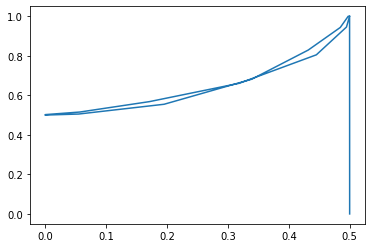

In [280]:
roc_curve(df['actual_label'],df['model_RF_bin'])